<a href="https://colab.research.google.com/github/ataev2808/nlp_models/blob/main/review_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.corpus import stopwords
import sklearn

from google.colab import drive
#drive.mount('/content/drive')
!gdown 1UwVq8dzWkpXZIQ5C227l15DUJ2kBqA4-

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Downloading...
From: https://drive.google.com/uc?id=1UwVq8dzWkpXZIQ5C227l15DUJ2kBqA4-
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 155MB/s]


In [ ]:
df = pd.read_csv('IMDB Dataset.csv')

In [ ]:
#инфа о датасете
df.shape
df.info()
df.duplicated().sum()
df.isnull().sum()
df[df.duplicated(keep=False)].sort_values('review')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative
...,...,...
47876,this movie sucks. did anyone notice that the e...,negative
44122,"well, the writing was very sloppy, the directi...",negative
23056,"well, the writing was very sloppy, the directi...",negative
10163,"when I first heard about this movie, I noticed...",positive


In [ ]:
!pip install wordcloud

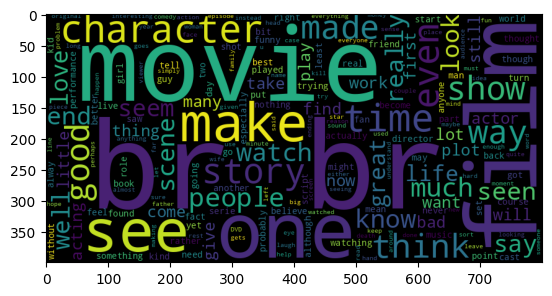

In [ ]:
# облако слов до очистки

from PIL import Image
from wordcloud import WordCloud

merged_text = ' '.join(df['review'])
wordcloud = WordCloud(width=800, height=400).generate(merged_text)
plt.imshow(wordcloud)


In [ ]:
# удаляю пустые значения, дубликаты, сбрасываю индексы

df = df.dropna(subset=['review', 'sentiment'])
df = df[df['review'].str.strip() != '']
df = df.drop_duplicates()
df = df.reset_index(drop=True)

df.shape

(49582, 2)

In [ ]:
# очищаю текст
def clean_text(text):
    text = str(text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r"[`´‘’“”„‟„`''``]+", '', text)
    text = re.sub(r'[^a-zA-Z0-9\s!?()]', '', text)   # оставил скобки, типо смайлы
    return text.lower()

clean_text = df['review'].apply(clean_text)
print(len(clean_text))


49582


Text(0.5, 1.0, 'Процентное распределение классов')

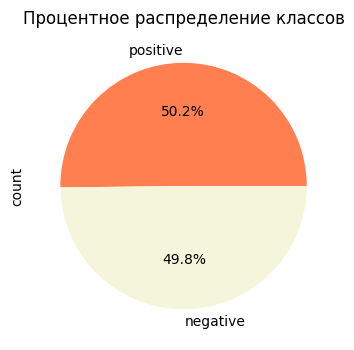

In [ ]:
# анализ баланса классов
plt.figure(figsize=(4, 4))
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=['coral','beige'])
plt.title('Процентное распределение классов')

In [ ]:
# токенизирую, удаляю стоп-слова
stop_words = set(stopwords.words("english"))

tokenize_text = [nltk.word_tokenize(sentence) for sentence in clean_text]
tokenize_text_wsws = [[word for word in sentence if word not in stop_words] for sentence in tokenize_text]

print(tokenize_text_wsws)
print(len(tokenize_text))

Buffered data was truncated after reaching the output size limit.

In [ ]:
# лемматизация

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

lemmatized_text = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in tokenize_text_wsws]
# print(lemmatized_text)

# обединяем токены в предложения
final_text = [" ".join(sentence) for sentence in lemmatized_text]
# print(final_text)

In [ ]:
# облако слов после очистки

merged_text = ' '.join(final_text)
wordcloud = WordCloud(width=800, height=400).generate(merged_text)
plt.imshow(wordcloud)

In [ ]:
# векторизация текста c помощью bag of words
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(ngram_range=(1, 2))
bag_of_words = count_vec.fit_transform(sentence for sentence in final_text) #мб надо создать глобальный словарь по всему корпусу
bag_of_words



In [ ]:
# векторизация текста c помощью tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(ngram_range=(1, 2))
tfidf = tfidf_vec.fit_transform(sentence for sentence in final_text)
tfidf
# tfidf_df =  pd.DataFrame(tfidf.toarray(), columns=tfidf_vec.get_feature_names_out(), index=final_text)
# tfidf_df

In [ ]:
# Обучение модели логистической регрессии
# разделение датасета на обучающий и тестовый наборы

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

df['final_text'] = [" ".join(sentence) for sentence in lemmatized_text]
# print("Размер df:", df.shape)
# print("Количество текстов:", len(df['final_text']))
X = df['final_text']
y = df['sentiment']
y = y.map({'positive': 1, 'negative': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# print(X)
# print(y)

In [ ]:
# выбор n-грамм
n1 = (1, 1)
n2 = (1, 2)

In [ ]:
# векторизация обучающего набора методом bow
from sklearn.preprocessing import MaxAbsScaler

vec = CountVectorizer(ngram_range=n2)
bow_train = vec.fit_transform(X_train)
bow_test = vec.transform(X_test)

# нормализация
scaler = MaxAbsScaler()
bow_train = scaler.fit_transform(bow_train)
bow_test = scaler.transform(bow_test)

# обучение с bow и лемматизацией
from sklearn.metrics import classification_report

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow_train, y_train)
pred = clf.predict(bow_test)
print(classification_report(y_test, pred))

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)

classes = ['Negative', 'Positive']

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Матрица ошибок')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Настоящий класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

In [ ]:
# векторизация обучающего набора методом tf-idf
from sklearn.preprocessing import MaxAbsScaler

vec = TfidfVectorizer(ngram_range=n2)
vec_train = vec.fit_transform(X_train)
vec_test = vec.transform(X_test)

# нормализация
scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

# обучение с tf-idf и лемматизацией
from sklearn.metrics import classification_report

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(vec_train, y_train)
pred = clf.predict(vec_test)
print(classification_report(y_test, pred))

# сохраняю веса
import joblib

joblib.dump(vec,       'tfidf_vectorizer.pkl')
joblib.dump(scaler,    'maxabs_scaler.pkl')
joblib.dump(clf,       'logistic_model.pkl')

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)

classes = ['Negative', 'Positive']

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Матрица ошибок')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Настоящий класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

In [ ]:
feature_names = vec.get_feature_names_out()
coefs = clf.coef_[0]
weights_df = pd.DataFrame({
    'word': feature_names,
    'weight': coefs
})

top_positive = weights_df.sort_values('weight', ascending=False).head(20)
top_negative = weights_df.sort_values('weight', ascending=True).head(20)

print("Топ-20 слов, которые сильно указывают на positive:")
print(top_positive)

print("\nТоп-20 слов, которые сильно указывают на negative:")
print(top_negative)

In [ ]:
# @title
# tf-idf без лемматизации

df['final_text_no_lemm'] = [" ".join(sentence) for sentence in tokenize_text_wsws]
# print("Размер df:", df.shape)
# print("Количество текстов:", len(df['final_text']))
X = df['final_text_no_lemm']
y = df['sentiment']
y = y.map({'positive': 1, 'negative': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

vec = TfidfVectorizer(ngram_range=n2)
vec_train = vec.fit_transform(X_train)
vec_test = vec.transform(X_test)

# нормализация
scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

# обучение с tf-idf и лемматизацией
from sklearn.metrics import classification_report

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(vec_train, y_train)
pred = clf.predict(vec_test)
print(classification_report(y_test, pred))


In [ ]:
# разбиение датасета с валидацией и обучение

df['final_text'] = [" ".join(sentence) for sentence in lemmatized_text]
# print("Размер df:", df.shape)
# print("Количество текстов:", len(df['final_text']))
X = df['final_text']
y = df['sentiment']
y = y.map({'positive': 1, 'negative': 0})
# на тест 30%
X_rest, X_test, y_rest, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# на валидацию 20%
val_size_relative = 0.20
X_train, X_val, y_train, y_val = train_test_split(
    X_rest, y_rest,
    test_size=val_size_relative,
    random_state=42,
    stratify=y_rest
)

clf = LogisticRegression(max_iter=200, random_state=42, C=1.0)
clf.fit(vec.fit_transform(X_train), y_train)


pred_val = clf.predict(vec.transform(X_val))
print("Validation:")
print(classification_report(y_val, pred_val))


# pred_test = clf.predict(vec.transform(X_test))
# print("\nFinal Test:")
# print(classification_report(y_test, pred_test))